# CSE 311 AI Project
2023BCS0023
Alex Gijo

**Project Title:** Real-Time Image Style Transfer Using CNNs

This notebook demonstrates training and inference for Image Style Transfer.

---

## Overview

Neural Style Transfer allows us to apply the artistic style of one image to the content of another. This implementation uses:

- **Generator Network**: Feed-forward CNN with residual blocks (TransformerNet)
- **Loss Function**: VGG16-based content, style, and total variation losses
- **Dataset**: COCO 2017 (subset of ~5,000 images at 256×256)
- **Training**: 5 epochs

---

## 1. Setup and Installation

In [5]:
# Clone the repository for accessing internal modules
!git clone https://github.com/Aroson1/AI_PROJECT
%cd AI_PROJECT

Cloning into 'AI_PROJECT'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 63 (delta 2), reused 58 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 20.09 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/AI_PROJECT


In [6]:
# Install dependencies
!pip install -q torch torchvision tqdm matplotlib Pillow numpy opencv-python

In [7]:
# Verify GPU availability
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 2. Download Dataset and Style Image

Here we are only using a subset of COCO 2017 dataset and a style image.

In [8]:
# Download COCO 2017 validation set (smaller than train set)
!wget -q http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip
print("COCO dataset downloaded!")

COCO dataset downloaded!


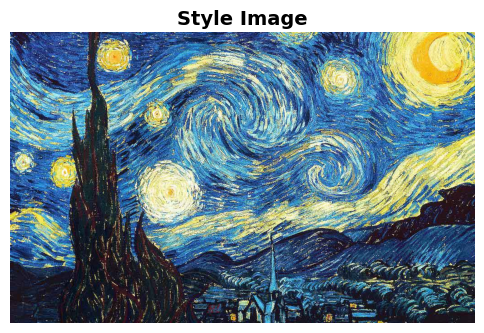

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Display the style image
# style_image_path = "picasso_selfportrait.jpg"
style_image_path = "starry_night.jpg"

if os.path.exists(style_image_path):
    style_img = Image.open(style_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(style_img)
    plt.title("Style Image", fontsize=14, fontweight="bold")
    plt.axis("off")
    plt.show()
else:
    print(f"Style image not found at {style_image_path}")
    print("Please upload a style image or update the path.")

## 3. Training Configuration

Setting up training parameters.

In [ ]:
config = {
    "dataset_path": "val2017",  # Path to COCO images
    "style_image": "starry_night.jpg",  # Style image path
    "epochs": 3,  # Number of training epochs
    "batch_size": 4,  # Batch size
    "image_size": 256,  # Image resolution (original uses 256)
    "style_size": 448,  # Style image size (original uses 448)
    "lr": 1e-3,  # Learning rate (original uses 1e-3)
    "content_weight": 1e5,  # Content loss weight (original: 10e5)
    "style_weight": 1e10,  # Style loss weight (original: 10e10)
    "tv_weight": 0,  # Total variation loss (not in original)
    "subset_size": 5000,  # Subset size for faster training
    "checkpoint_dir": "models/checkpoints",
    "checkpoint_interval": 200,  # Save checkpoint every N batches
    "sample_interval": 200,  # Save sample images every N batches
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

In [ ]:
import sys

sys.path.append("src")

import os
import time
import torch
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from src.transformer import TransformerNet
from src.vgg_loss import StyleTransferLoss
from src.datasets import create_dataloader, get_style_image_transform

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}\n")

# Create output directory
os.makedirs(config["checkpoint_dir"], exist_ok=True)

# Initialize model
print("Initializing transformer network...")
transformer = TransformerNet().to(device)
num_params = sum(p.numel() for p in transformer.parameters())
print(f"Model parameters: {num_params:,}\n")

# Initialize loss function
print("Initializing loss function with VGG16...")
loss_fn = StyleTransferLoss(
    content_weight=config["content_weight"],
    style_weight=config["style_weight"],
    tv_weight=config["tv_weight"],
).to(device)

# Initialize optimizer
optimizer = optim.Adam(transformer.parameters(), lr=config["lr"])
print(f"Optimizer: Adam (lr={config['lr']})\n")

Training on device: cuda

Initializing transformer network...
Model parameters: 1,676,035

Initializing loss function with VGG19...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Optimizer: Adam (lr=0.001)



In [ ]:
# Load and pre-process style image
print(f"Loading style image: {config['style_image']}")
style_transform = get_style_image_transform(
    config.get("style_size", config["image_size"])
)
style_image = Image.open(config["style_image"]).convert("RGB")
style_tensor = style_transform(style_image).unsqueeze(0).to(device)

# Repeat style tensor for batch processing (original approach)
style_tensor = style_tensor.repeat(config["batch_size"], 1, 1, 1)

# Pre-compute style Gram matrices
print("Computing style features...")
style_grams = loss_fn.extract_style_gram(style_tensor)
print("Style features computed!\n")

Loading style image: starry_night.jpg
Computing style features...
Style features computed!



In [25]:
# Create dataloader
print(f"Loading dataset from: {config['dataset_path']}")
dataloader = create_dataloader(
    config["dataset_path"],
    batch_size=config["batch_size"],
    image_size=config["image_size"],
    subset_size=config["subset_size"],
    shuffle=True,
    num_workers=2,
)
print(f"Dataloader ready: {len(dataloader)} batches per epoch\n")

Loading dataset from: val2017
Loaded 5000 images from val2017
Dataloader ready: 1250 batches per epoch



In [17]:
# Training loop
print("=" * 60)
print(f"Starting Training: {config['epochs']} epochs")
print("=" * 60)

loss_history = {"total": [], "content": [], "style": [], "tv": []}

for epoch in range(config["epochs"]):
    transformer.train()
    epoch_losses = {"total": 0, "content": 0, "style": 0, "tv": 0}
    num_batches = 0

    epoch_start_time = time.time()

    # Progress bar
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")

    for batch_idx, content_batch in enumerate(pbar):
        content_batch = content_batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        generated_batch = transformer(content_batch)

        # Compute loss
        losses = loss_fn(
            generated_batch, content_batch, style_features_gram=style_grams
        )

        # Backward pass
        losses["total"].backward()
        optimizer.step()

        # Accumulate losses
        epoch_losses["total"] += losses["total"].item()
        epoch_losses["content"] += losses["content"]
        epoch_losses["style"] += losses["style"]
        epoch_losses["tv"] += losses["tv"]
        num_batches += 1

        # Update progress bar
        pbar.set_postfix(
            {
                "loss": f"{losses['total'].item():.2f}",
                "content": f"{losses['content']:.2f}",
                "style": f"{losses['style']:.2f}",
            }
        )

    # Calculate average losses
    avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}

    # Store losses
    for key in loss_history:
        loss_history[key].append(avg_losses[key])

    epoch_time = time.time() - epoch_start_time

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{config['epochs']} - Time: {epoch_time:.2f}s")
    print(f"  Avg Total Loss:   {avg_losses['total']:.4f}")
    print(f"  Avg Content Loss: {avg_losses['content']:.4f}")
    print(f"  Avg Style Loss:   {avg_losses['style']:.4f}")
    print(f"  Avg TV Loss:      {avg_losses['tv']:.6f}\n")

    # Save checkpoint
    checkpoint_path = os.path.join(
        config["checkpoint_dir"], f"checkpoint_epoch_{epoch+1}.pth"
    )
    torch.save(transformer.state_dict(), checkpoint_path)
    print(f"✓ Checkpoint saved: {checkpoint_path}\n")

# Save final model
final_model_path = os.path.join(config["checkpoint_dir"], "final_model.pth")
torch.save(transformer.state_dict(), final_model_path)

print("=" * 60)
print("Training Complete!")
print(f"Final model saved: {final_model_path}")
print("=" * 60)

Starting Training: 5 epochs


Epoch 1/5: 100%|██████████| 1250/1250 [04:58<00:00,  4.19it/s, loss=131.35, content=26.81, style=0.00]



Epoch 1/5 - Time: 298.23s
  Avg Total Loss:   1938.7075
  Avg Content Loss: 22.4948
  Avg Style Loss:   0.0038
  Avg TV Loss:      0.030930

✓ Checkpoint saved: models/checkpoints/checkpoint_epoch_1.pth



Epoch 2/5: 100%|██████████| 1250/1250 [05:00<00:00,  4.17it/s, loss=76.46, content=29.48, style=0.00]



Epoch 2/5 - Time: 300.07s
  Avg Total Loss:   98.4058
  Avg Content Loss: 24.2143
  Avg Style Loss:   0.0001
  Avg TV Loss:      0.080957

✓ Checkpoint saved: models/checkpoints/checkpoint_epoch_2.pth



Epoch 3/5: 100%|██████████| 1250/1250 [05:00<00:00,  4.16it/s, loss=53.56, content=32.41, style=0.00]



Epoch 3/5 - Time: 300.63s
  Avg Total Loss:   59.0186
  Avg Content Loss: 25.6205
  Avg Style Loss:   0.0001
  Avg TV Loss:      0.110981

✓ Checkpoint saved: models/checkpoints/checkpoint_epoch_3.pth



Epoch 4/5: 100%|██████████| 1250/1250 [05:00<00:00,  4.16it/s, loss=43.12, content=25.98, style=0.00]



Epoch 4/5 - Time: 300.73s
  Avg Total Loss:   46.0398
  Avg Content Loss: 26.0660
  Avg Style Loss:   0.0000
  Avg TV Loss:      0.119135

✓ Checkpoint saved: models/checkpoints/checkpoint_epoch_4.pth



Epoch 5/5: 100%|██████████| 1250/1250 [05:00<00:00,  4.16it/s, loss=39.22, content=24.21, style=0.00]


Epoch 5/5 - Time: 300.67s
  Avg Total Loss:   41.0269
  Avg Content Loss: 25.8715
  Avg Style Loss:   0.0000
  Avg TV Loss:      0.121904

✓ Checkpoint saved: models/checkpoints/checkpoint_epoch_5.pth

Training Complete!
Final model saved: models/checkpoints/final_model.pth


## 5. Visualize Training Progress

Plot the loss curves to see how the model learned.

Loss plot saved: models/checkpoints/loss_plot.png


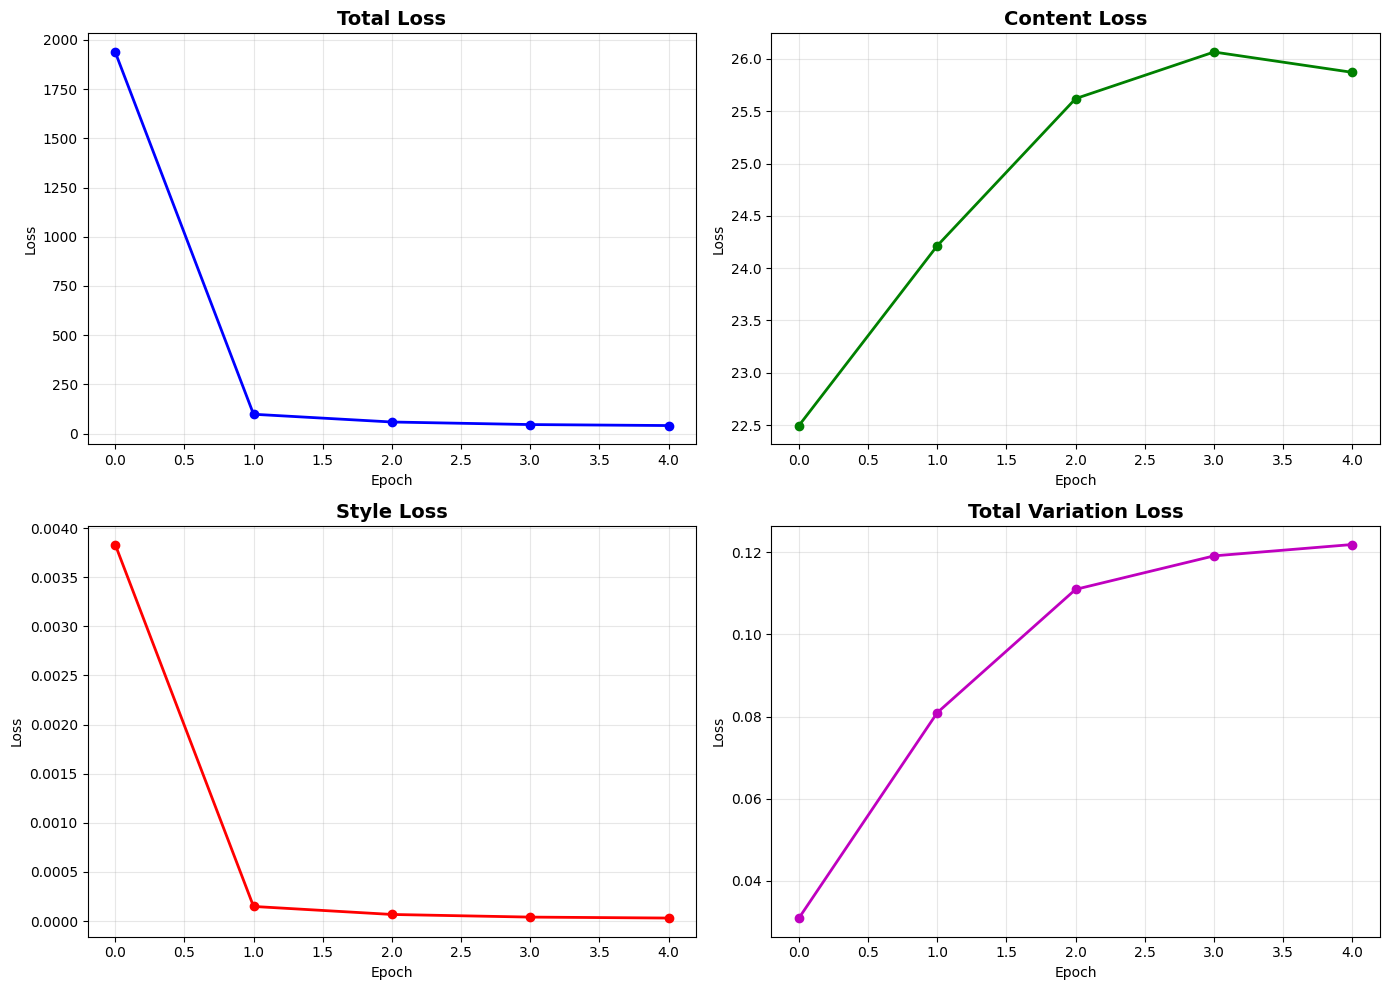

In [18]:
# Plot loss curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss
axes[0, 0].plot(loss_history["total"], "b-", linewidth=2, marker="o")
axes[0, 0].set_title("Total Loss", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].grid(True, alpha=0.3)

# Content loss
axes[0, 1].plot(loss_history["content"], "g-", linewidth=2, marker="o")
axes[0, 1].set_title("Content Loss", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].grid(True, alpha=0.3)

# Style loss
axes[1, 0].plot(loss_history["style"], "r-", linewidth=2, marker="o")
axes[1, 0].set_title("Style Loss", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].grid(True, alpha=0.3)

# TV loss
axes[1, 1].plot(loss_history["tv"], "m-", linewidth=2, marker="o")
axes[1, 1].set_title("Total Variation Loss", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
loss_plot_path = os.path.join(config["checkpoint_dir"], "loss_plot.png")
plt.savefig(loss_plot_path, dpi=150, bbox_inches="tight")
print(f"Loss plot saved: {loss_plot_path}")
plt.show()

## 6. Inference - Stylize Test Images

Use the trained model to stylize new images.

In [ ]:
# Load the trained model
from src.inference import load_model, stylize_image
from src.datasets import tensor_to_image

# Load model
model = load_model(final_model_path, device=device)
print("Model loaded for inference!")

Loading model from: models/checkpoints/final_model.pth
Model loaded successfully!
Model loaded for inference!


Stylized image saved to: stylized_output.jpg


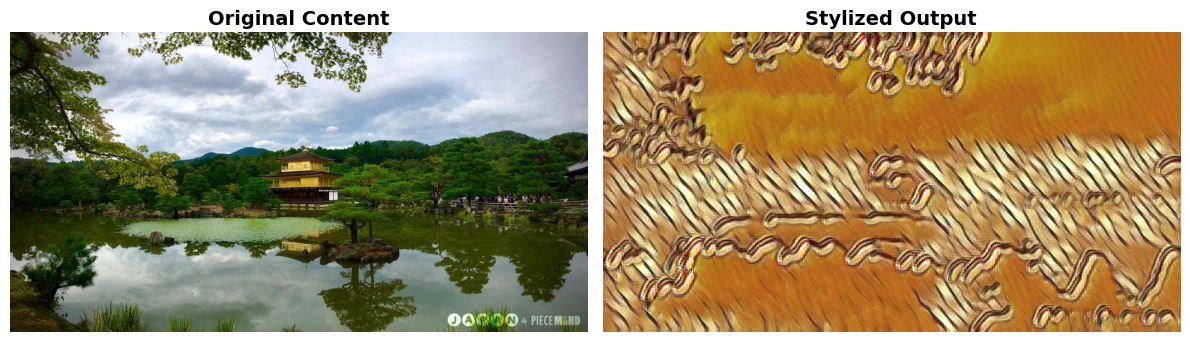

In [22]:
# Test on a sample image
test_image_path = "japanese_garden.jpg"  # Or upload your own

if os.path.exists(test_image_path):
    output = stylize_image(
        model,
        test_image_path,
        output_path="stylized_output.jpg",
        device=device,
        display=True,
    )
else:
    print(f"Test image not found: {test_image_path}")
    print("Please upload an image or use an image from COCO dataset.")

Stylized image saved to: output.jpg
Stylized image saved to: output.jpg
Stylized image saved to: output.jpg


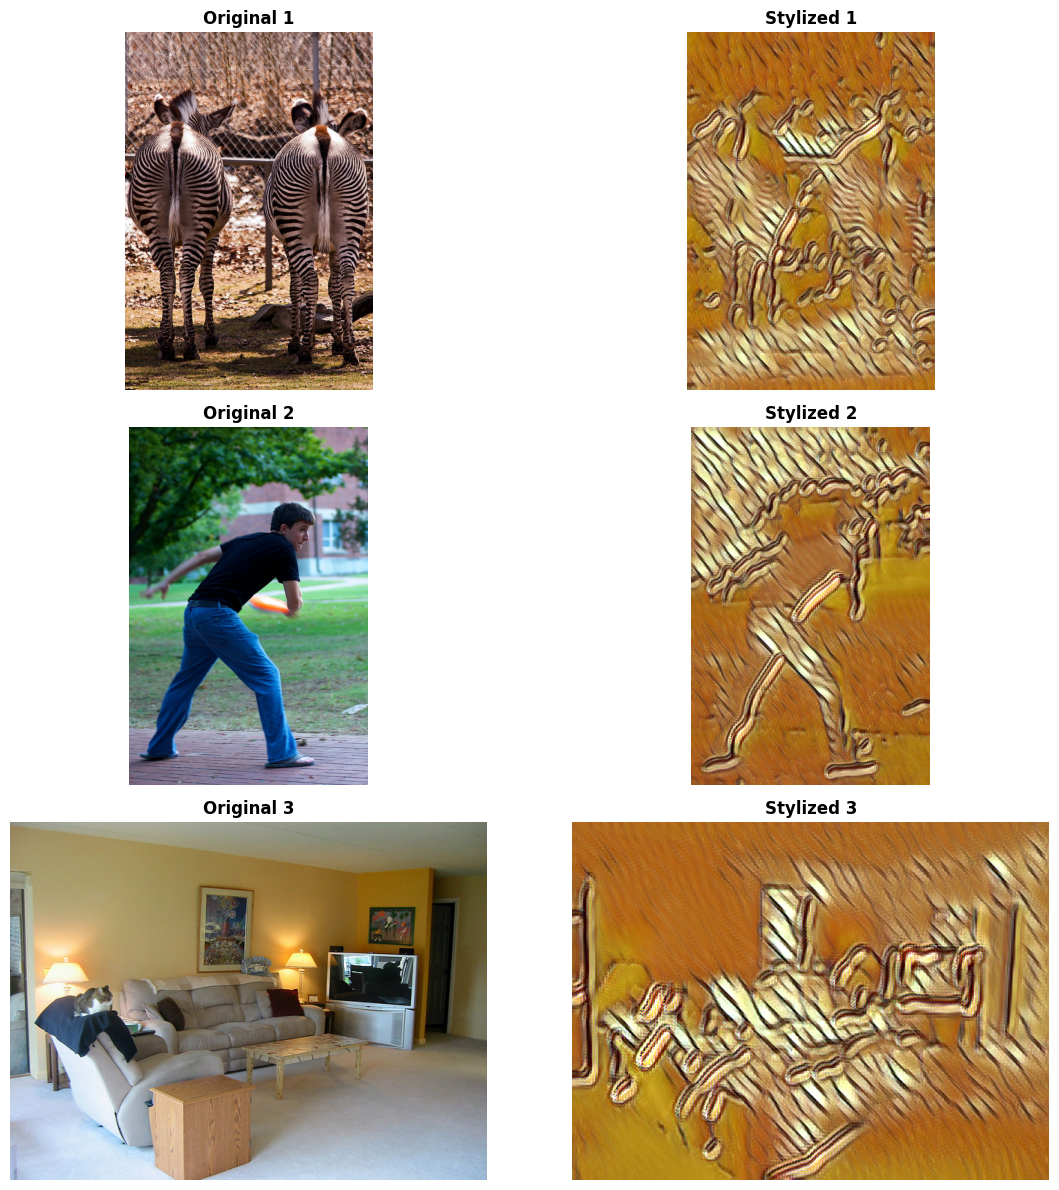


Sample results saved to: sample_results.png


In [23]:
# Test on multiple sample images from COCO
import random
from src.datasets import get_test_image_transform

# Get random images from dataset
coco_images = [
    os.path.join(config["dataset_path"], f)
    for f in os.listdir(config["dataset_path"])
    if f.endswith(".jpg")
][
    :10
]  # Get first 10

# Select 3 random images
sample_images = random.sample(coco_images, min(3, len(coco_images)))

fig, axes = plt.subplots(len(sample_images), 2, figsize=(12, 4 * len(sample_images)))

for idx, img_path in enumerate(sample_images):
    # Load content image
    content_img = Image.open(img_path).convert("RGB")

    # Stylize
    output = stylize_image(model, img_path, device=device, display=False)

    # Display
    if len(sample_images) == 1:
        axes[0].imshow(content_img)
        axes[0].set_title("Original", fontsize=12, fontweight="bold")
        axes[0].axis("off")

        axes[1].imshow(output)
        axes[1].set_title("Stylized", fontsize=12, fontweight="bold")
        axes[1].axis("off")
    else:
        axes[idx, 0].imshow(content_img)
        axes[idx, 0].set_title(f"Original {idx+1}", fontsize=12, fontweight="bold")
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(output)
        axes[idx, 1].set_title(f"Stylized {idx+1}", fontsize=12, fontweight="bold")
        axes[idx, 1].axis("off")

plt.tight_layout()
plt.savefig("sample_results.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nSample results saved to: sample_results.png")